True vs. Estimated:
a: true=1.000000  est=0.999255
b: true=0.100000  est=0.099942
c: true=1.500000  est=1.501552
d: true=0.075000  est=0.075066


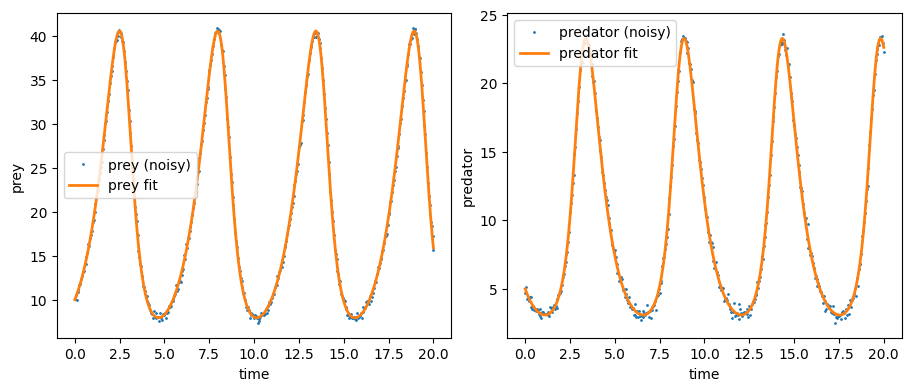

In [ ]:

import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Lotka–Volterra (prey x, predator y):
# dx/dt =  a*x - b*x*y
# dy/dt = -c*y + d*x*y
# a = tumor proliferation rate
# b = tumor death rate from effector cell
# c = Effector cell death rate
# d = Effector cell proliferation rate
def lv(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

@dataclass
class SimSpec:
    t0: float = 0.0 #start time
    t1: float = 20.0 #end time 
    n: int = 401 # numb of data points
    x0: float = 10.0   # initial prey
    y0: float = 5.0    # initial predators
    sigma: float = 0.3 # additive Gaussian noise SD

#synthetic data
true_params = np.array([1.0, 0.1, 1.5, 0.075])  #(a, b, c, d)
spec = SimSpec()
t_eval = np.linspace(spec.t0, spec.t1, spec.n)

sol_true = solve_ivp(  #ode solver
    #z'(t) = f(t, z(t)) - integrates the system of odes at time t
    #z(t) = the state of the popualtions (rabbits, wolves)
    lambda t, z: lv(t, z, *true_params), 
    # this is gets the values of pred and prey at time t, unpacks true param into lv (a,b,c,d)
    (spec.t0, spec.t1), #start and end time 
    [spec.x0, spec.y0], #start populations for pred and prey 
    t_eval=t_eval, #points at which to report values from the model
    rtol=1e-8, # relative tolerance (controls proportional accuracy)
     atol=1e-10 # absolute tolerance (controls floor of accuracy for tiny numbers)
)

rng = np.random.default_rng(42)
Y_clean = sol_true.y.T                            # shape (401, 2)
Y_noisy = Y_clean + spec.sigma * rng.standard_normal(Y_clean.shape)  #generating noisy dataset

#can asuume that the noise is negigible sp i can remove

#2) Define loss and refit parameters

#now that we have created the synthic data we now will try to imagine we don't know the pararmeters, 
#and will try to make guess what the parameters are.
def simulate(params):
    a, b, c, d = params
    sol = solve_ivp(
        lambda t, z: lv(t, z, a, b, c, d), #guessing parms
        (spec.t0, spec.t1),  #time
        [spec.x0, spec.y0],  #intial conditions
        t_eval=t_eval,
        rtol=1e-6, atol=1e-8
    )
    return sol.y.T  # (401, 2)

# Residuals (stack prey and predator residuals)
def residuals(theta_log):
    theta = np.exp(theta_log)
    Y_hat = simulate(theta) #run model with guessing parameters
    return (Y_hat - Y_noisy).ravel() #difference between guess and simulated data

theta0 = np.log(np.array([0.8, 0.08, 1.5, 0.06]))  # rough initial guess
res = least_squares(residuals, theta0, method="trf", ftol=1e-10, xtol=1e-10, gtol=1e-10, max_nfev=200) # optimizer
#continuously runs until we find a values for parameters that minimize the resiudal beteween simulated and guessing data


est_params = np.exp(res.x)
names = ["a", "b", "c", "d"]
print("True vs. Estimated:")
for n, t, e in zip(names, true_params, est_params):
    print(f"{n}: true={t:.6f}  est={e:.6f}")

# Plot
Y_fit = simulate(est_params)
fig, ax = plt.subplots(1, 2, figsize=(9, 3.8), constrained_layout=True)
ax[0].plot(t_eval, Y_noisy[:,0], ".", ms=2, label="prey (noisy)")
ax[0].plot(t_eval, Y_fit[:,0], "-", lw=2, label="prey fit")
ax[0].set_xlabel("time"); ax[0].set_ylabel("prey"); ax[0].legend()

ax[1].plot(t_eval, Y_noisy[:,1], ".", ms=2, label="predator (noisy)")
ax[1].plot(t_eval, Y_fit[:,1], "-", lw=2, label="predator fit")
ax[1].set_xlabel("time"); ax[1].set_ylabel("predator"); ax[1].legend()

plt.show()


#Im going to start trying to relate this to cancer dynamics. so say the cancer cell popuation is represented by rabbits. uncontrolled this is what their growth should look like  

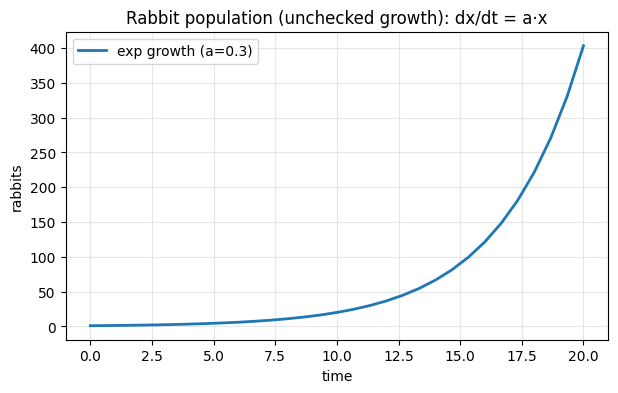

In [6]:
import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def rabbits(t,x,a):
    return x*a
@dataclass 
class SimulateData:
    t0: float = 0.0
    t1: float = 20.0
    n: int = 30
    x0: int = 1

a = 0.3
spec = SimulateData()
t_eval = np.linspace(spec.t0, spec.t1, spec.n + 1)

sol = solve_ivp(
    fun=lambda t, x: rabbits(t, x, a),  # corrected
    t_span=(spec.t0, spec.t1),
    y0=[spec.x0],
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-10,
)

x = sol.y[0]

plt.figure(figsize=(7, 4))
plt.plot(t_eval, x, lw=2, label=f"exp growth (a={a})")
plt.xlabel("time")
plt.ylabel("rabbits")
plt.title("Rabbit population (unchecked growth): dx/dt = a·x")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

now I'll add the ideal, which should be zero rabbits (zero cancer cells)

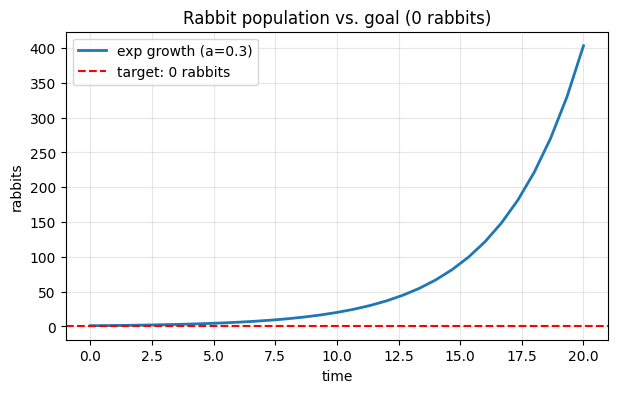

In [8]:
plt.figure(figsize=(7,4))
plt.plot(t_eval, x, lw=2, label=f"exp growth (a={a})")
plt.axhline(0, color="red", linestyle="--", label="target: 0 rabbits")
plt.xlabel("time")
plt.ylabel("rabbits")
plt.title("Rabbit population vs. goal (0 rabbits)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#now ill re-add locka-volterave (idk how to spell it) so that we can see how our rabbit pop (cancer cells) are being effected by wolves(treatment) and how they induce proximity to the zero line over time.

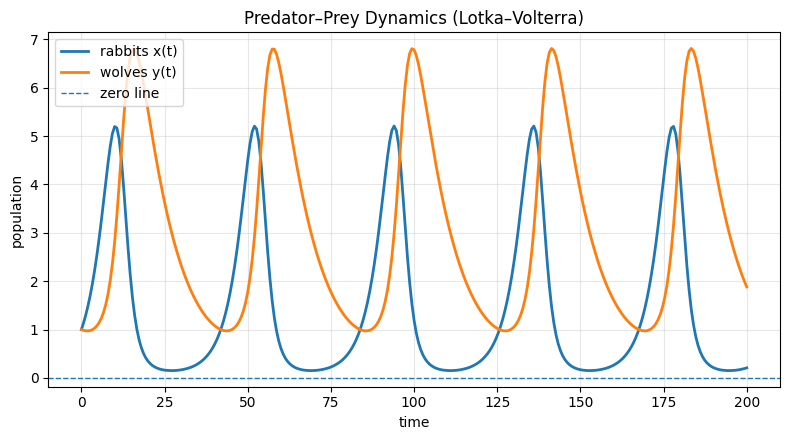

In [9]:
import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def rabbits_with_the_wolves(t, z, a, b, c, d):
    x, y = z
    # optionally clamp tiny negative numerical noise
    x = max(x, 0.0); y = max(y, 0.0)
    dx = a * x - b * x * y     # prey growth minus predation
    dy = c * x * y - d * y     # predator gain from predation minus natural death
    return [dx, dy]

@dataclass 
class SimulateData:
    t0: float = 0.0
    t1: float = 200.0
    n: int = 300
    x0: float = 1.0
    y0: float = 1.0

initial_params = np.array([0.3, 0.1, 0.07, 0.1])  # a, b, c, d
spec = SimulateData()

t_eval = np.linspace(spec.t0, spec.t1, spec.n + 1)

sol = solve_ivp(
    fun=lambda t, z: rabbits_with_the_wolves(t, z, *initial_params),
    t_span=(spec.t0, spec.t1),
    y0=[spec.x0, spec.y0],
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-10,
)

x = sol.y[0]
y = sol.y[1]

plt.figure(figsize=(8, 4.5))
plt.plot(t_eval, x, lw=2, label="rabbits x(t)")
plt.plot(t_eval, y, lw=2, label="wolves y(t)")
plt.axhline(0, ls="--", lw=1, label="zero line")
plt.xlabel("time")
plt.ylabel("population")
plt.title("Predator–Prey Dynamics (Lotka–Volterra)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The best way to get 0 rabbits would be a bunch of wolves( max concentration chemo) but we can't do that (bc it'll kill our patient) so this si my attempt at imputing a limiter on the amount of wolves that we're able to add to our simulation so we can see how that effects rabbit population

In [10]:
def u_of_t(t, umax, t_on=0.0, t_off=200.0):
    return umax if (t_on <= t <= t_off) else 0.0

def prey_predator_with_control(t, z, a, b, c, d, umax):
    x, y = z
    x = max(x, 0.0); y = max(y, 0.0)
    dx = a*x - b*x*y
    dy = c*x*y - d*y + u_of_t(t, umax=umax)
    return [dx, dy]

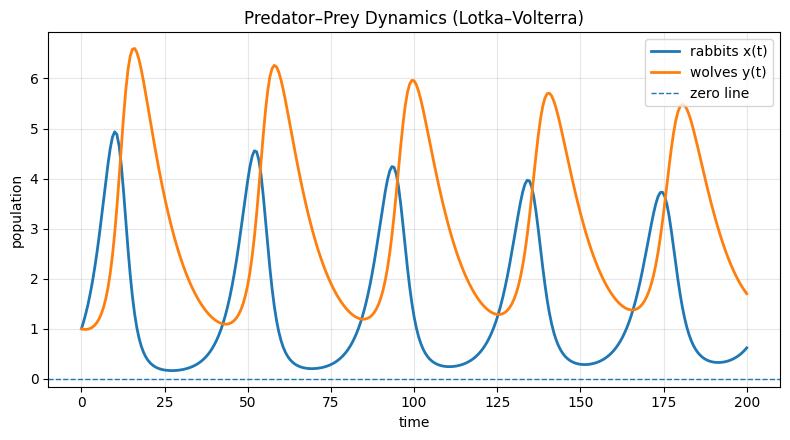

In [12]:
sol = solve_ivp(
    fun=lambda t, z: prey_predator_with_control(t, z, *initial_params,  umax = 0.01),
    t_span=(spec.t0, spec.t1),
    y0=[spec.x0, spec.y0],
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-10,
)

x = sol.y[0]
y = sol.y[1]

plt.figure(figsize=(8, 4.5))
plt.plot(t_eval, x, lw=2, label="rabbits x(t)")
plt.plot(t_eval, y, lw=2, label="wolves y(t)")
plt.axhline(0, ls="--", lw=1, label="zero line")
plt.xlabel("time")
plt.ylabel("population")
plt.title("Predator–Prey Dynamics (Lotka–Volterra)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
